Code to produce plots for scaling relations. Uses the data in `../300km/output`, `../500km/output`, and `../800km/output`

To use this notebook, simply run all the cells. The last cell loops over all the results and creates the associated plots. In order to reference the model runs that do not include a thermal stable layer, change `stable_layer = True` to `stable_layer = False` in the last cell.

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import sys

from matplotlib.backends.backend_pdf import PdfPages
import matplotlib
matplotlib.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica'], 'size':'18'})
matplotlib.rc('text', usetex=False)

sys.path.append('C:\\Users\\earcd\\Documents\\GitHub\\thermal_history')

import os
import csv

In [14]:
def scalings(rs, rho, omega, sigma, EJ, Tmean):
    """B2 ∼ ρ * μ0 * L**(2/3) * p**(2/3)
       p = PA/(rho*V) = DO + DV ≈ (EJ*Tmean)/(rho*V)
       
       The factor of (rho*V) arises because the MAc balance in 
       https://doi.org/10.1093/gji/ggab342 (eqn 3) is derived from 
       the NS eqn divided by  rho, while the energy balance (eqn 4) is 
       derived from the kinetic energy equation without dividing by rho.
       """

    mu0    = 4.0*np.pi*1e-7 # Magnetic permeability of vacuum (H/m)   
    eta    = 1e0/(mu0*sigma)
        
    prefac = 1.0
    exp_En = 1e0/3e0               # Exponent for scaling
    d      = rs                    # (convecting) outer core thickness
    Voc    = 4.0*np.pi*(rs**3)/3.0 # Outer core volume
    
    P      = np.zeros(EJ.size)
    P[EJ>0]= EJ[EJ>0]*Tmean/(rho[0]*Voc[EJ>0]) #Avoid negative Ej.

    Brms   = prefac * (rho[0]*mu0)**0.5 * (d**exp_En) * (P)**exp_En #RMS internal field strength

    Ro     = (P / (omega**3 * rs**2))**(4e0/9e0)                    #Rossby number
    Rm     = Ro * omega * d**2 / eta                                #Magnetic Reynolds number 
    lp     = (P / (omega**3 * rs**2))**( 1e0/9e0)   * rs            #l_perp
    MEKE   = (P / (omega**3 * rs**2))**(-2e0/9e0)                   #ME/KE    
            
    return Brms, Ro, Rm, lp, MEKE
    

In [15]:
def plot_scalings(data, name, B, Ro, Rm, l, ignore_last_datapoint=True):
    
    fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(16,8))

    time   = data['core']['time'] / (1e6*data['parameters']['ys'])  #Convert time from seconds to Myrs.
    
    if ignore_last_datapoint:
        idx = time.size-1
    else:
        idx = time.size

    ax1.plot(time[:idx], B[:idx]*1000)
    ax1.set_xlabel('time [Myrs]')
    ax1.set_ylabel('Brms [mT]')
    ax2.plot(time[:idx], Rm[:idx])
    ax2.plot(time[:idx], 50*np.ones(len(Rm[:idx])))
    ax2.set_xlabel('time [Myrs]')
    ax2.set_ylabel('$Rm$')   

    ax3.plot(time[:idx], Ro[:idx])
    ax3.set_xlabel('time [Myrs]')
    ax3.set_ylabel('$Ro$')
    ax3.set_yscale('log')
    ax4.plot(time[:idx], l[:idx]/1e3)
    ax4.set_xlabel('time [Myrs]')
    ax4.set_ylabel('$l$ (km)')
    
    fig.savefig(name+"_scaling.pdf", format='pdf',bbox_inches="tight")
    plt.close(fig)   

In [16]:
def plot_single_ts(data, name, field, ls, lc, figure=None, ax=None, ignore_last_datapoint=True, legend=None):
    
    if figure == None:
        fig, ax = plt.subplots(figsize=(16,6))

    time     = data['core']['time'] / (1e6*data['parameters']['ys'])  #Convert time from seconds to Myrs.
    variable = data['core'][field]  

    if ignore_last_datapoint:
        idx = time.size-1
    else:
        idx = time.size
        
    if field == "conc_l":
        label = "$\\xi_l / \\xi_0$ in liquid"
        var   = variable/variable[0]
    elif field == "Ej":
        label = '$E_J$ (MW K$^{-1}$)'
        var   = variable / 1e6
    elif field == "r_snow":
        label = '$r_s$ (km)'
        var   = variable / 1000
    elif field == "Tcen":
        label = '$T_{\\rm cen} / T_{\\rm cen, 0}$'
        var   = variable/variable[0]
    else:
        label = field
        var   = variable
                
    str1 = name.split('/')[-1]
    strS = str1.split('_')[0]
    strQ = str1.split('_')[-1]
    S= strS.split('=')[-1]
    Q= strQ.split('=')[-1]
    string = "$\\xi_0 = $" + S + " wt%, $Q = $" + str(Q) + "W m$^{-2}$"

    ax.plot(time[:idx], var[:idx], linestyle=ls, color=lc, linewidth=3, label=string)  #Remove any file paths from name
    ax.set_xlabel('time [Myrs]', fontsize = 20.0)
    ax.set_ylabel(label, fontsize = 20.0)
    if legend: 
        ax.legend(bbox_to_anchor=(0.5, 0.2), ncol=1, fontsize = 18.0)
    
    if figure == None:
        fig.savefig(name+"_"+field+".pdf", format='pdf',bbox_inches="tight")
        plt.close(fig)

In [17]:
def plot_Q(data, fields, name, ignore_last_datapoint=True):
    
    fig, ax = plt.subplots(figsize=(16,6))
 
    time   = data['core']['time'] / (1e6*data['parameters']['ys'])  #Convert time from seconds to Myrs.

    Qs   = data['core']['Qs']/1e10
    Qa   = data['core']['Qa']/1e10
    Qcmb = data['core']['Q_cmb']/1e10
    Qls  = data['core']['Ql_s']/1e10
    Qll  = data['core']['Ql_l']/1e10
    Qlb  = data['core']['Ql_b']/1e10
    Qgb  = data['core']['Qg_b']/1e10
    Qgs  = data['core']['Qg_s']/1e10
    Qgl  = data['core']['Qg_l']/1e10   
  
    if ignore_last_datapoint:
        idx = time.size-1
    else:
        idx = time.size

    plt.plot(time[:idx], Qcmb[:idx], 'black' , label='$Q_{cmb}$', linewidth=3)
    plt.plot(time[:idx], Qs[:idx]  , 'purple', label='$Q_s$'    , linewidth=3)
    plt.plot(time[:idx], Qa[:idx]  , 'grey'  , label='$Q_a$'    , linewidth=3)
    plt.plot(time[:idx], Qls[:idx] , 'g-'    , label='$Q_l^s$'  , linewidth=3)
    plt.plot(time[:idx], Qll[:idx] , 'g--'   , label='$Q_l^l$'  , linewidth=3)
    plt.xlabel('time (Mys)')
    plt.ylabel('$Q$ ($\\times 10^{10}$ W)')
    
    plt.xlim([0,time[-1]])

    if fields == 1: # plot the small terms
        plt.plot(time[:idx], Qlb[:idx] , 'g:' , label='$Q_l^b$', linewidth=2)
        plt.plot(time[:idx], Qgb[:idx] , 'c:' , label='$Q_g^b$', linewidth=2)
        plt.plot(time[:idx], Qgs[:idx] , 'c-' , label='$Q_g^s$', linewidth=2)
        plt.plot(time[:idx], Qgl[:idx] , 'c--', label='$Q_g^l$', linewidth=2) 
        plt.legend(loc="best", ncol=2)
        fig.savefig(name+"_Q_all.pdf", format='pdf',bbox_inches="tight")
        fig.savefig(name+"_Q_all.png", format='png',bbox_inches="tight")
    else:
        if Qgs[idx-1] > Qgl[idx-1]:  #Index -2 since last value is when r_snow=0 and energies/entropies are not defined.
            plt.plot(time[:idx], Qgs[:idx] , 'c-', label='$Q_g^s$')
        else:
            plt.plot(time[:idx], Qgl[:idx], 'c--', label='$Q_g^l$')    
        plt.legend(loc="best", ncol=3)
        fig.savefig(name+"_Q_red.pdf", format='pdf',bbox_inches="tight")
        fig.savefig(name+"_Q_red.png", format='png',bbox_inches="tight")
    
    plt.close(fig)
    

In [18]:
def plot_E(data, fields, name, ignore_last_datapoint=True):
    
    fig, ax = plt.subplots(figsize=(16,6))

    time   = data['core']['time'] / (1e6*data['parameters']['ys'])  #Convert time from seconds to Myrs.

    Ea   = data['core']['Ea']/1e6
    Es   = data['core']['Es']/1e6
    EJ   = data['core']['Ej']/1e6
    Ek   = data['core']['Ek']/1e6
    Els  = data['core']['El_s']/1e6
    Ell  = data['core']['El_l']/1e6
    Elb  = data['core']['El_b']/1e6
    Egs  = data['core']['Eg_s']/1e6
    Egl  = data['core']['Eg_l']/1e6
    Egb  = data['core']['Eg_b']/1e6

    if ignore_last_datapoint:
        idx = time.size-1
    else:
        idx = time.size

    plt.plot(time[:idx], EJ[:idx]  , 'black'  , label='$E_J$', linewidth=3)
    plt.plot(time[:idx], Ek[:idx]  , 'dimgrey', label='$E_k$', linewidth=3)
    plt.plot(time[:idx], Egs[:idx] , 'c-'     , label='$E_g^s$', linewidth=3)
    plt.plot(time[:idx], Egl[:idx] , 'c--'    , label='$E_g^l$', linewidth=3)
    plt.xlabel('time (Myrs)')
    plt.ylabel('Entropy (MW K$^{-1}$)')
    
    plt.xlim([0,time[-1]])
    
    if fields == 1: # plot the small terms
        plt.plot(time[:idx], Ea[:idx]  , 'grey'   , label='$E_a$')
        plt.plot(time[:idx], Es[:idx]  , 'purple' , label='$E_s$')
        plt.plot(time[:idx], Elb[:idx] , 'g:' , label='$E_l^b$')
        plt.plot(time[:idx], Egb[:idx] , 'c:' , label='$E_g^b$')
        plt.plot(time[:idx], Els[:idx] , 'g-' , label='$E_l^s$')
        plt.plot(time[:idx], Ell[:idx] , 'g--', label='$E_l^l$')
        plt.legend(loc=0, ncol=2)
        fig.savefig(name+"_E_all.pdf", format='pdf',bbox_inches="tight")
        fig.savefig(name+"_E_all.png", format='png',bbox_inches="tight")
    else:
        if Els[idx-1] > Ell[idx-1]:  
            plt.plot(time[:idx], Els[:idx] , 'g-' , label='$E_l^s$', linewidth=3)
        else:
            plt.plot(time[:idx], Ell[:idx] , 'g--', label='$E_l^l$', linewidth=3)
        plt.legend(loc="best", ncol=3)
        fig.savefig(name+"_E_red.pdf", format='pdf',bbox_inches="tight")
        fig.savefig(name+"_E_red.png", format='png',bbox_inches="tight")
    
    plt.close(fig)

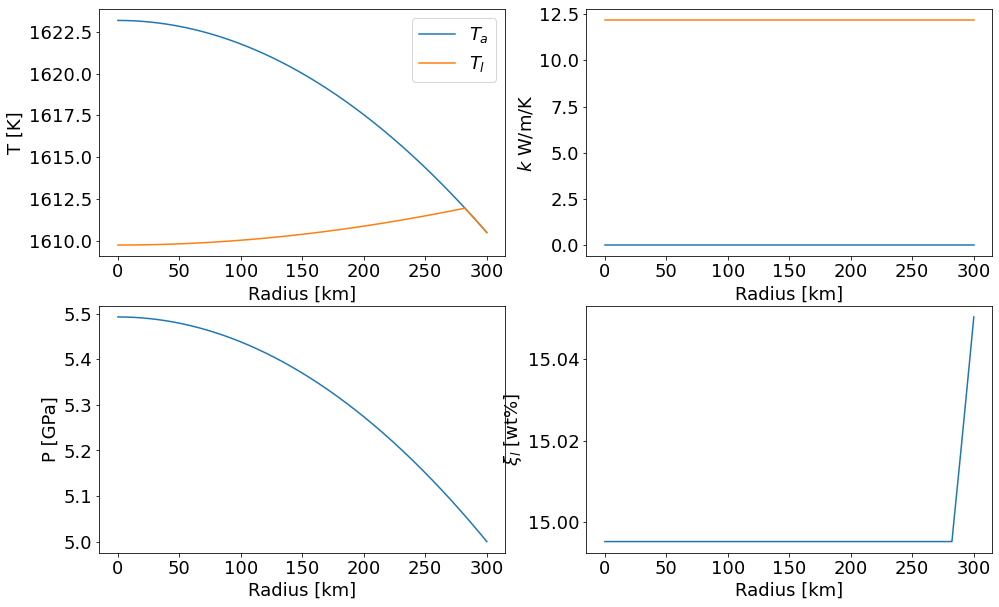

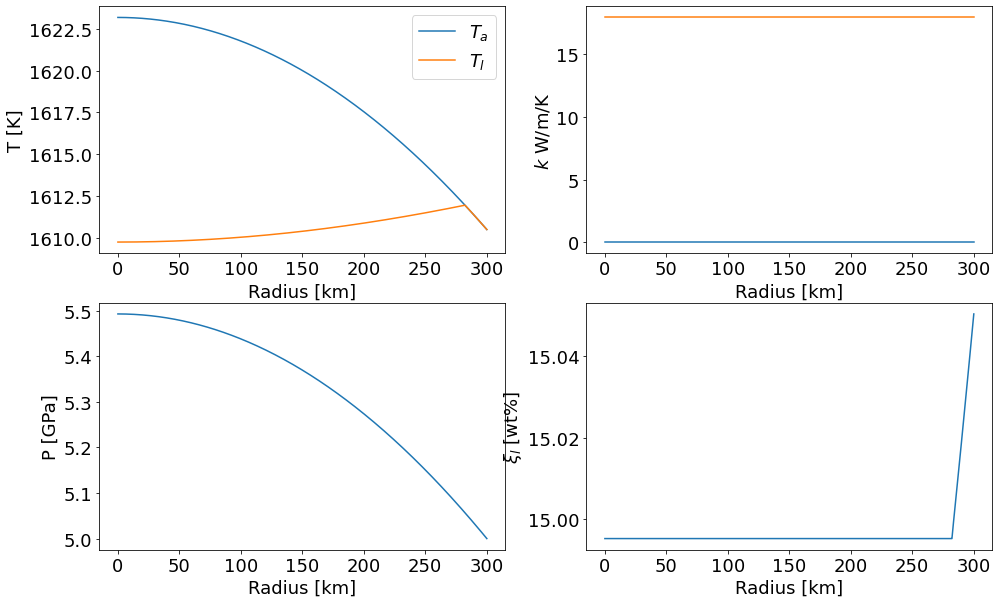

In [19]:
def plot_profs(fname):
    
    """Plots profiles of core properties. Keys are: 
    
    Core: dict_keys('r', 'rho', 'g', 'P', 'cp', 'alpha', 
    'psi', 'Ta', 'dTa_dr', 'T', 'conc_l', 'dS', 'Tm_fe', 
    'Tm', 'dTm_dP', 'k', 'Qa', 'L', 'Cl', 'phi_snow')
        
    """

    data = pickle.load(open(fname+".pik", 'rb')) #Read in dictionary from binary file
            
    rc    = data['core']['profiles']['r']/1e3
    rhoc  = data['core']['profiles']['rho']
    Pc    = data['core']['profiles']['P']
    Ta    = data['core']['profiles']['Ta']
    Tmc   = data['core']['profiles']['Tm']
    cl    = data['core']['profiles']['conc_l']
    phi   = data['core']['profiles']['phi_snow']
    k     = data['core']['profiles']['k']
            
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2,figsize=(16,10))

    ax1.plot(rc, Ta   , label="$T_a$")   
    ax1.plot(rc, Tmc  , label="$T_l$")    
    ax1.set_ylabel('T [K]')
    ax1.set_xlabel('Radius [km]')
    ax1.legend()    
        
    ax2.plot(rc, phi  , label="$\phi$")    
    ax2.set_ylabel("$\\phi$")
    ax2.set_xlabel('Radius [km]')
    
    ax2.plot(rc, k)    
    ax2.set_ylabel("$k$ W/m/K")
    ax2.set_xlabel('Radius [km]')
    
    ax3.plot(rc, Pc/1e9)
    ax3.set_xlabel('Radius [km]')
    ax3.set_ylabel("P [GPa]")
    
    ax4.plot(rc, cl*100)
    ax4.set_xlabel('Radius [km]')
    ax4.set_ylabel('$\\xi_l$ [wt%]')
    
    #fig.savefig(fname+"_1Dstate.png")    
    
file = "../300km/output_snow/S=15_q=10_adiabatic_profiles_200"
plot_profs(file)
file = "../300km/output_snow_kelFeSVostryakov/S=15_q=10_adiabatic_profiles_200"
plot_profs(file)

Plotting rc=300


C:\Users\earcd\AppData\Local\Temp\ipykernel_37824\2773635904.py:24: RuntimeWarning: invalid value encountered in true_divide
  Ro     = (P / (omega**3 * rs**2))**(4e0/9e0)                    #Rossby number
C:\Users\earcd\AppData\Local\Temp\ipykernel_37824\2773635904.py:26: RuntimeWarning: invalid value encountered in true_divide
  lp     = (P / (omega**3 * rs**2))**( 1e0/9e0)   * rs            #l_perp
C:\Users\earcd\AppData\Local\Temp\ipykernel_37824\2773635904.py:27: RuntimeWarning: invalid value encountered in true_divide
  MEKE   = (P / (omega**3 * rs**2))**(-2e0/9e0)                   #ME/KE
C:\Users\earcd\AppData\Local\Temp\ipykernel_37824\2773635904.py:27: RuntimeWarning: divide by zero encountered in power
  MEKE   = (P / (omega**3 * rs**2))**(-2e0/9e0)                   #ME/KE
C:\Users\earcd\AppData\Local\Temp\ipykernel_37824\2773635904.py:20: RuntimeWarning: divide by zero encountered in double_scalars
  P[EJ>0]= EJ[EJ>0]*Tmean/(rho[0]*Voc[EJ>0]) #Avoid negative Ej.
C:\Users\e

Plotting rc=500


C:\Users\earcd\AppData\Local\Temp\ipykernel_37824\2773635904.py:24: RuntimeWarning: invalid value encountered in true_divide
  Ro     = (P / (omega**3 * rs**2))**(4e0/9e0)                    #Rossby number
C:\Users\earcd\AppData\Local\Temp\ipykernel_37824\2773635904.py:26: RuntimeWarning: invalid value encountered in true_divide
  lp     = (P / (omega**3 * rs**2))**( 1e0/9e0)   * rs            #l_perp
C:\Users\earcd\AppData\Local\Temp\ipykernel_37824\2773635904.py:27: RuntimeWarning: invalid value encountered in true_divide
  MEKE   = (P / (omega**3 * rs**2))**(-2e0/9e0)                   #ME/KE
C:\Users\earcd\AppData\Local\Temp\ipykernel_37824\2773635904.py:27: RuntimeWarning: divide by zero encountered in power
  MEKE   = (P / (omega**3 * rs**2))**(-2e0/9e0)                   #ME/KE
C:\Users\earcd\AppData\Local\Temp\ipykernel_37824\2773635904.py:20: RuntimeWarning: divide by zero encountered in double_scalars
  P[EJ>0]= EJ[EJ>0]*Tmean/(rho[0]*Voc[EJ>0]) #Avoid negative Ej.
C:\Users\e

Plotting rc=800


C:\Users\earcd\AppData\Local\Temp\ipykernel_37824\2773635904.py:24: RuntimeWarning: invalid value encountered in true_divide
  Ro     = (P / (omega**3 * rs**2))**(4e0/9e0)                    #Rossby number
C:\Users\earcd\AppData\Local\Temp\ipykernel_37824\2773635904.py:26: RuntimeWarning: invalid value encountered in true_divide
  lp     = (P / (omega**3 * rs**2))**( 1e0/9e0)   * rs            #l_perp
C:\Users\earcd\AppData\Local\Temp\ipykernel_37824\2773635904.py:27: RuntimeWarning: invalid value encountered in true_divide
  MEKE   = (P / (omega**3 * rs**2))**(-2e0/9e0)                   #ME/KE
C:\Users\earcd\AppData\Local\Temp\ipykernel_37824\2773635904.py:27: RuntimeWarning: divide by zero encountered in power
  MEKE   = (P / (omega**3 * rs**2))**(-2e0/9e0)                   #ME/KE
C:\Users\earcd\AppData\Local\Temp\ipykernel_37824\2773635904.py:24: RuntimeWarning: invalid value encountered in true_divide
  Ro     = (P / (omega**3 * rs**2))**(4e0/9e0)                    #Rossby numbe

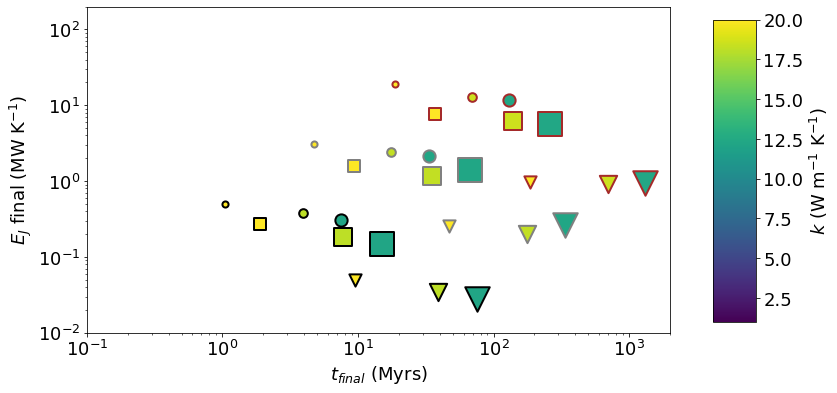

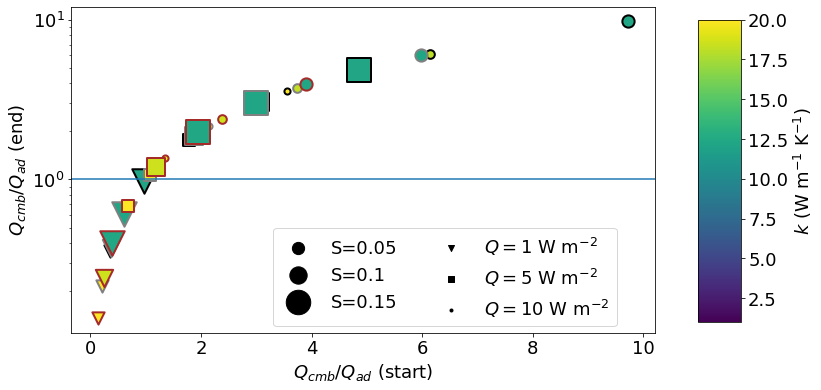

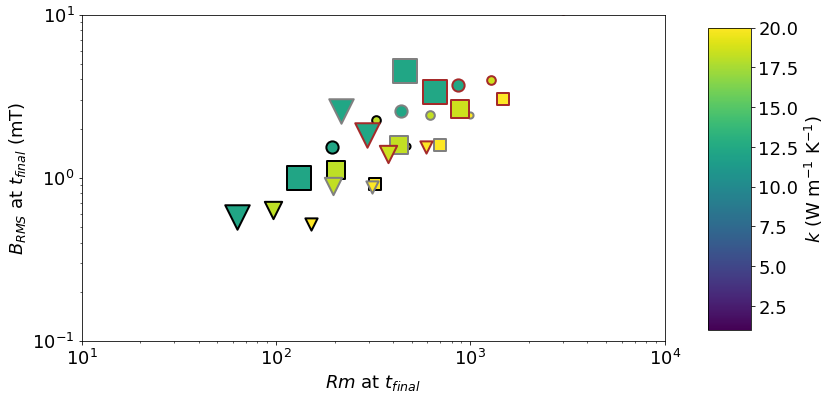

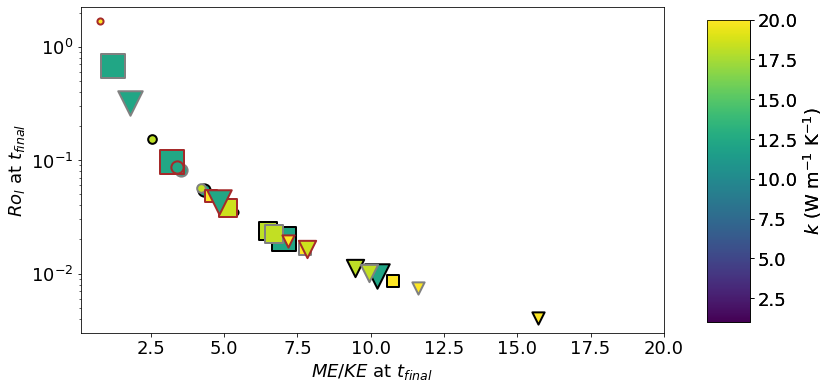

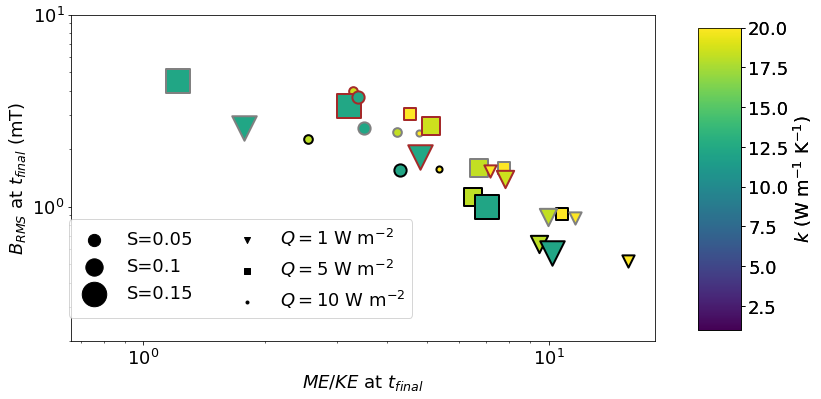

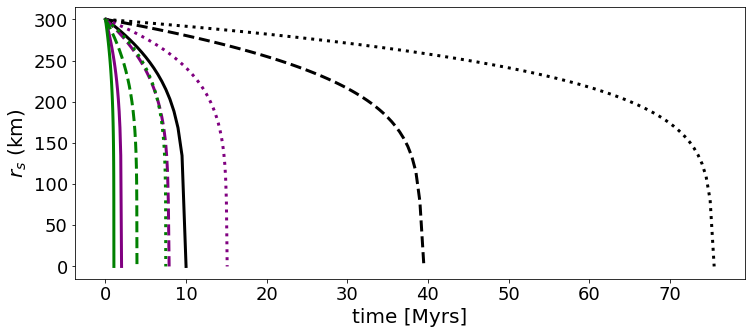

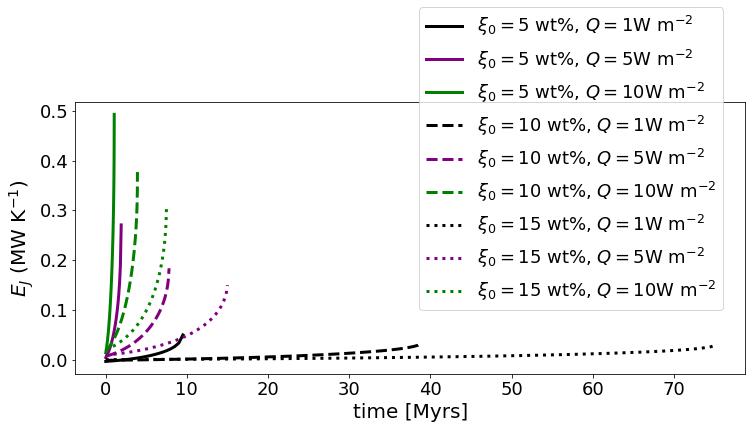

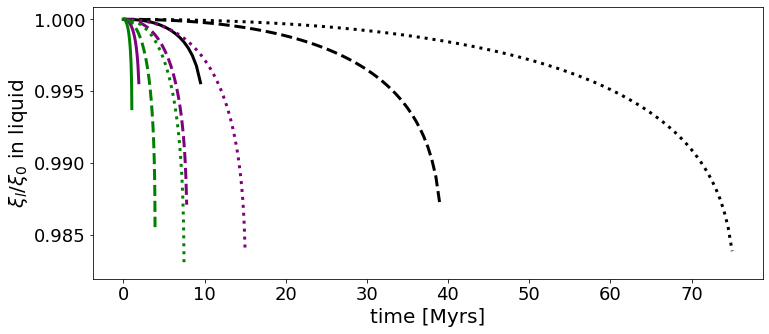

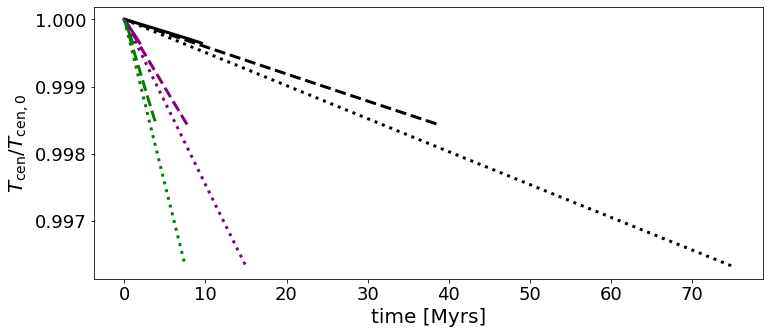

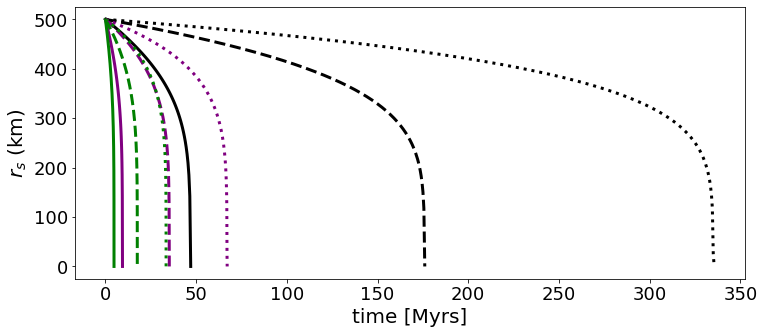

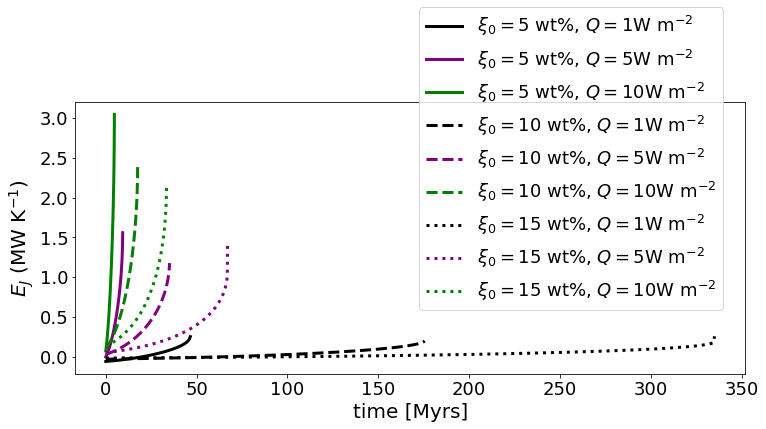

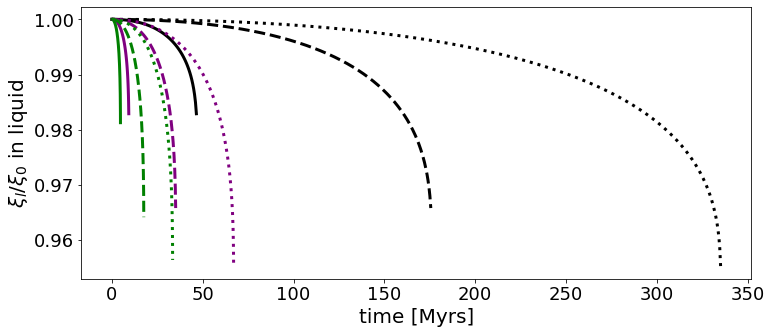

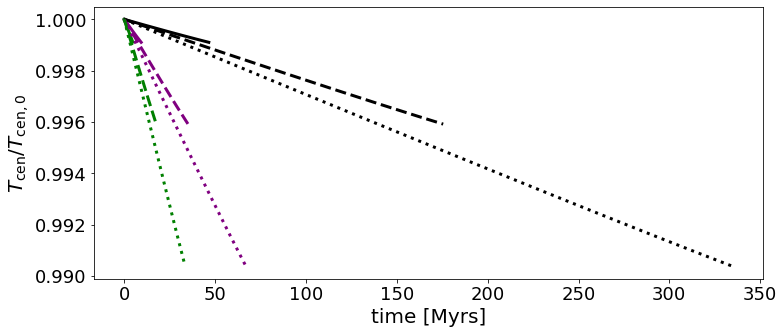

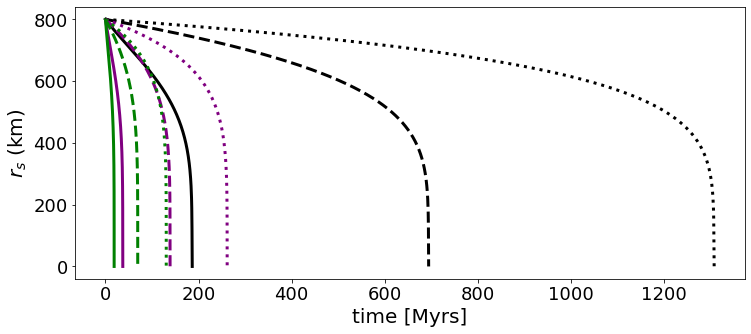

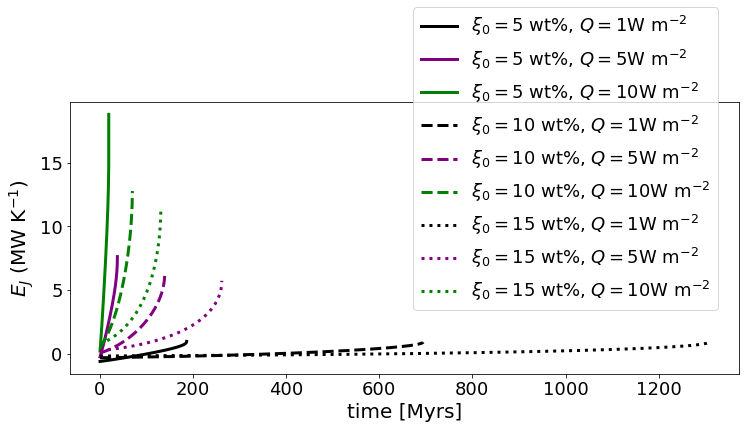

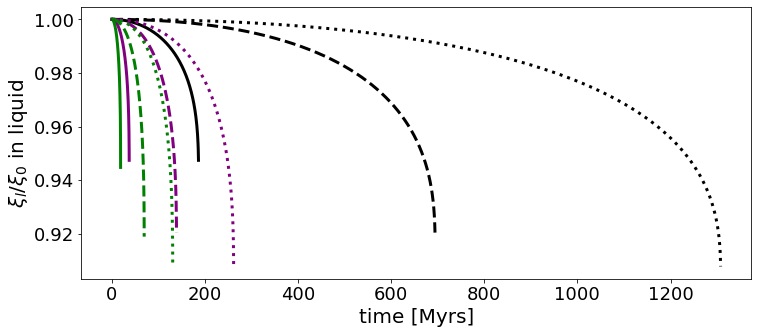

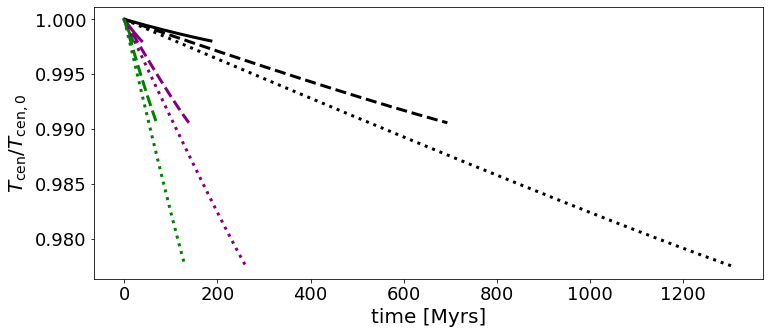

In [21]:
rc_array    = [300, 500, 800]
q_cmb_array = [1, 5, 10]        #mW/m^2
S_array     = [0.05, 0.1, 0.15] # snow
#S_array     = [0.25, 0.3, 0.35] # flotation

symbol = ['v', 's', '.']
size   = [150, 300, 600]
edge   = ["black", "grey", "brown"]
lc     = ["black", "purple", "green"]
ls     = ["-", "--", ":"]

stable_layer  = False
snow_or_float = "snow"
whichk        = "kelFeSVostryakov"
whichk        = ""

header = ['file', 'S_conc', 'Qcmb_final', 'Qa_final', 't_final(Myrs)', 'r_cmb', 'rsnow_final', 'Pcen', 
          'kcmb_final', 'sigma', 'Lcmb', 'Tmcmb', 'EJ_final', 'ADR_final', 'Brms_final', 'Ro_final', 'Rm_final', 
          'lp final', 'MEKE_Final', 'rho_solid', 'rho_liquid', 'rho', 'entropy_melting', 'alpha_c', 
          'Cp', 'alphaT', 'failure_reason']

colormap = "viridis"

fig1, ax1 = plt.subplots(figsize=(12,6))
fig2, ax2 = plt.subplots(figsize=(12,6))
fig3, ax3 = plt.subplots(figsize=(12,6))
fig4, ax4 = plt.subplots(figsize=(12,6))
fig9, ax9 = plt.subplots(figsize=(12,6))

for rr, r_cmb in enumerate(rc_array):

    print(f'Plotting rc={r_cmb}')
    
    out_folder = 'scaling_plots_'+snow_or_float+whichk
    if not stable_layer:
        out_folder += '_adiabatic'
    out_regime = out_folder
        
    if not os.path.isdir(out_folder):   #Make top level directory for output
        os.mkdir(out_folder)

    out_folder += f'/{r_cmb}km/'        #Create folder for specific sized core.
    if not os.path.isdir(out_folder):
        os.mkdir(out_folder)
        
    csv_name   = out_folder+'/run_summary_all.csv'
    fall       = open(csv_name, 'w',newline='')
    write_all  = csv.writer(fall)
    write_all.writerow(header)

    data = {}
    tf   = []

    ADRs  = np.zeros(len(S_array)*len(q_cmb_array))
    ADRe  = np.zeros(len(S_array)*len(q_cmb_array))

    fig5, ax5 = plt.subplots(figsize=(12,5))
    fig6, ax6 = plt.subplots(figsize=(12,5))
    fig7, ax7 = plt.subplots(figsize=(12,5))
    fig8, ax8 = plt.subplots(figsize=(12,5))

    omega = 2*np.pi / (28*60*60*24)

    #Begin loops
    j = 0
    for SS,S in enumerate(S_array):
        for qq,q_cmb in enumerate(q_cmb_array):

            name = f'S={S*100:.0f}_q={q_cmb:.0f}'
            if whichk == "":
                file = f'../{r_cmb}km/output_{snow_or_float}/{name}'
            elif whichk == "kelFeSVostryakov":
                file = f'../{r_cmb}km/output_{snow_or_float}_kelFeSVostryakov/{name}'                
            
            if not stable_layer:
                file += '_adiabatic'
            file += '.pik'

            if os.path.exists(file):
                with open(file,'rb') as open_file:
                    data[j] = pickle.load(open_file)
            else: 
                print("Failed soln at ", name)
                continue    
                
            rho_solid  = data[j]['parameters']['core_solid_density_params']
            rho_liquid = data[j]['parameters']['core_liquid_density_params']
            rho        = data[j]['core']['profiles']['rho'][0], data[j]['core']['profiles']['rho'][-1]
            dS         = data[j]['core']['profiles']['dS'][0] , data[j]['core']['profiles']['dS'][-1]
            alpha_c    = data[j]['parameters']['alpha_c']
            Lc         = data[j]['core']['L_r_snow'][-1]
                        
            Qa         = data[j]['core']['Qa'][-1]/1e10
            Qc         = data[j]['core']['Q_cmb'][-1]/1e10
            SCMB_pres  = data[j]['core']['profiles']['conc_l'][-1]
            Pc         = data[j]['core']['profiles']['P'][0]
            Tmc        = data[j]['core']['profiles']['Tm'][-1]
            Cp         = data[j]['parameters']['core_cp_params']
            alphaT     = data[j]['parameters']['core_alpha_T_params']
            
            k  = data[j]['core']['profiles']['k'][-1]
            rs = data[j]['core']['r_snow']
            rc = data[j]['parameters']['r_cmb']
            sigma = 1e0/((92.71381967698574 + 1189.0330473455936*S + 2404.678175564527*S**2)*1e-8)
                                    
            fail = data[j]['core']['critical_failure_reason']
                        
            cbar_param = k
            vmin = 1.0
            vmax = 20.0
            
            # ***** Regime diagram *****
            
            # Ej and final time
            tf.append(data[j]['core']['time'][-1] - data[j]['core']['time'][rs<rc][0])
            EJf = data[j]['core']['Ej'][-2]      
            im = ax1.scatter(tf[j]/(1e6*data[j]['parameters']['ys']), EJf/1e6, s=size[SS], marker=symbol[qq], 
                             edgecolor=edge[rr], linewidth=2, c=cbar_param, vmin=vmin, vmax=vmax, cmap=colormap)
            
            # Qcmb/Qad
            ADRs[j] = data[j]['core']['ADR'][0]       
            ADRe[j] = data[j]['core']['ADR'][-2]       
            ax2.scatter(ADRs[j], ADRe[j], s=size[SS], marker=symbol[qq], edgecolor=edge[rr],
                             linewidth=2, c=cbar_param, vmin=vmin, vmax=vmax, cmap=colormap)
        
            # Davidson scalings
            # CD 09/05/2023 - changed rc -> rs ????? Use rs for now. 
            Brms, Ro, Rm, lp, MEKE = scalings(rs, data[j]['core']['profiles']['rho'], omega, sigma,
                                        data[j]['core']['Ej'], np.mean(data[j]['core']['profiles']['T']))
            plot_scalings(data[j], out_folder+name, Brms, Ro, Rm, lp)
            
            # Brms vs Rm
            ax3.scatter(Rm[-2], Brms[-2]*1000, s=size[SS], marker=symbol[qq], edgecolor=edge[rr],
                             linewidth=2, c=cbar_param, vmin=vmin, vmax=vmax, cmap=colormap)
            
            # ME/KE vs Rol
            ax4.scatter(MEKE[-2], Ro[-2], s=size[SS], marker=symbol[qq], edgecolor=edge[rr],
                             linewidth=2, c=cbar_param, vmin=vmin, vmax=vmax, cmap=colormap)
            
            # ME/KE vs Rol
            ax9.scatter(MEKE[-2], Brms[-2]*1000  , s=size[SS], marker=symbol[qq], edgecolor=edge[rr],
                             linewidth=2, c=cbar_param, vmin=vmin, vmax=vmax, cmap=colormap)
            
            plot_Q(data[j],1, out_folder+name)
            plot_E(data[j],1, out_folder+name)
            plot_Q(data[j],2, out_folder+name)
            plot_E(data[j],2, out_folder+name)
            plot_single_ts(data[j], out_folder+name, 'r_snow', ls[SS], lc[qq], fig5, ax5, ignore_last_datapoint=False) # All runs on same plot
            plot_single_ts(data[j], out_folder+name, 'Ej'    , ls[SS], lc[qq], fig6, ax6, legend=1)
            plot_single_ts(data[j], out_folder+name, 'conc_l', ls[SS], lc[qq], fig7, ax7)
            plot_single_ts(data[j], out_folder+name, 'Tcen'  , ls[SS], lc[qq], fig8, ax8)
            plot_single_ts(data[j], out_folder+name, 'r_snow', ls[SS], lc[qq])                                         # Plots for each run
            
            row = [open_file, S, Qc, Qa, tf[j]/(60*60*24*365e6), rc/1e3, rs[-1]/1e3, Pc/1e9,
                   k, sigma, Lc, Tmc, EJf, ADRe[j],
                   Brms[-2], Ro[-2], Rm[-2], lp[-2], MEKE[-2], 
                   rho_solid[0], rho_liquid[0], rho[0], dS[0], alpha_c[0], Cp, alphaT, fail]
            write_all.writerow(row)
            
            j = j + 1

    fig5.savefig(out_folder+"rsnow_all.pdf", format='pdf',bbox_inches="tight")
    fig6.savefig(out_folder+"Ej_all.pdf"   , format='pdf',bbox_inches="tight")
    fig7.savefig(out_folder+"concl_all.pdf", format='pdf',bbox_inches="tight")
    fig8.savefig(out_folder+"Tcen_all.pdf" , format='pdf',bbox_inches="tight")
    fig5.savefig(out_folder+"rsnow_all.png", format='png',bbox_inches="tight")
    fig6.savefig(out_folder+"Ej_all.png"   , format='png',bbox_inches="tight")
    fig7.savefig(out_folder+"concl_all.png", format='png',bbox_inches="tight")
    fig8.savefig(out_folder+"Tcen_all.png" , format='png',bbox_inches="tight")
      
    # Ej and final time
    if rr == 1: # Only set labels once
        ax1.set_xlabel("$t_{final}$ (Myrs)")
        ax1.set_ylabel("$E_J$ final (MW K$^{-1}$)")
        fig1.subplots_adjust(right=0.8)
        cbar_ax = fig1.add_axes([0.85, 0.15, 0.05, 0.7])
        fig1.colorbar(im, cax = cbar_ax, label="$k$ (W m$^{-1}$ K$^{-1}$)")
    fig1.savefig(out_folder+"regime_tf_Ejf.pdf", format='pdf',bbox_inches="tight")
    fig1.savefig(out_folder+"regime_tf_Ejf.png", format='png',bbox_inches="tight")

    # Qcmb/Qad
    if rr == 1: 
        ax2.set_xlabel("$Q_{cmb}/Q_{ad}$ (start)")
        ax2.set_ylabel("$Q_{cmb}/Q_{ad}$ (end)")
        ax2.axhline(1)
        ax2.set_yscale('log')
        fig2.subplots_adjust(right=0.8)
        cbar_ax = fig2.add_axes([0.85, 0.15, 0.05, 0.7])
        fig2.colorbar(im, cax = cbar_ax, label="$k$ (W m$^{-1}$ K$^{-1}$)")
    fig2.savefig(out_folder+"regime_ADRs_ADRf.pdf", format='pdf',bbox_inches="tight")
    fig2.savefig(out_folder+"regime_ADRs_ADRf.png", format='png',bbox_inches="tight")

    if rr == 1: 
        ax3.set_xlabel("$Rm$ at $t_{final}$")
        ax3.set_ylabel("$B_{RMS}$ at $t_{final}$ (mT)")
        fig3.subplots_adjust(right=0.8)
        cbar_ax = fig3.add_axes([0.85, 0.15, 0.05, 0.7])
        fig3.colorbar(im, cax = cbar_ax, label="$k$ (W m$^{-1}$ K$^{-1}$)")
    fig3.savefig(out_folder+"regime_Rmf_Bf.pdf", format='pdf',bbox_inches="tight")
    fig3.savefig(out_folder+"regime_Rmf_Bf.png", format='png',bbox_inches="tight")

    if rr == 1: 
        ax4.set_ylabel("$Ro_l$ at $t_{final}$")
        ax4.set_xlabel(r"$ME/KE$ at $t_{final}$")
        ax4.set_yscale('log')
        fig4.subplots_adjust(right=0.8)
        cbar_ax = fig4.add_axes([0.85, 0.15, 0.05, 0.7])
        fig4.colorbar(im, cax = cbar_ax, label="$k$ (W m$^{-1}$ K$^{-1}$)")
    fig4.savefig(out_folder+"regime_Rof_MEKE.pdf", format='pdf',bbox_inches="tight")
    fig4.savefig(out_folder+"regime_Rof_MEKE.png", format='png',bbox_inches="tight")
    
    if rr == 1: 
        ax9.set_ylabel("$B_{RMS}$ at $t_{final}$ (mT)")
        ax9.set_xlabel(r"$ME/KE$ at $t_{final}$")
        fig9.subplots_adjust(right=0.8)
        cbar_ax = fig9.add_axes([0.85, 0.15, 0.05, 0.7])
        fig9.colorbar(im, cax = cbar_ax, label="$k$ (W m$^{-1}$ K$^{-1}$)")
    fig9.savefig(out_folder+"regime_MEKE_Brms.pdf", format='pdf',bbox_inches="tight")
    fig9.savefig(out_folder+"regime_MEKE_Brms.png", format='png',bbox_inches="tight")

# Ej and final time
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlim([1e-1, 2e3])
ax1.set_ylim([1e-2, 2e2])
ax1.scatter(1,-100,c='k',s=size[0],label="S="+str(S_array[0]))
ax1.scatter(1,-100,c='k',s=size[1],label="S="+str(S_array[1]))
ax1.scatter(1,-100,c='k',s=size[2],label="S="+str(S_array[2]))
ax1.scatter(1,-100,c='k',marker=symbol[0],label="$Q=1$ W m$^{-2}$")
ax1.scatter(1,-100,c='k',marker=symbol[1],label="$Q=5$ W m$^{-2}$")
ax1.scatter(1,-100,c='k',marker=symbol[2],label="$Q=10$ W m$^{-2}$")
#fig1.subplots_adjust(right=0.8)
#cbar_ax = fig1.add_axes([0.85, 0.15, 0.05, 0.7])
#fig1.colorbar(im, cax = cbar_ax, label="$k$ (W m$^{-1}$ K$^{-1}$)")
fig1.savefig(out_regime+"regime_tf_Ejf.pdf", format='pdf',bbox_inches="tight")
fig1.savefig(out_regime+"regime_tf_Ejf.png", format='png',bbox_inches="tight")
    
# Qcmb/Qad
ax2.set_yscale('log')
#ax2.set_xscale('log')
ax2.scatter(1,-100,c='k',s=size[0],label="S="+str(S_array[0]))
ax2.scatter(1,-100,c='k',s=size[1],label="S="+str(S_array[1]))
ax2.scatter(1,-100,c='k',s=size[2],label="S="+str(S_array[2]))
ax2.scatter(1,-100,c='k',marker=symbol[0],label="$Q=1$ W m$^{-2}$")
ax2.scatter(1,-100,c='k',marker=symbol[1],label="$Q=5$ W m$^{-2}$")
ax2.scatter(1,-100,c='k',marker=symbol[2],label="$Q=10$ W m$^{-2}$")
ax2.legend(bbox_to_anchor=(0.95, 0.35), ncol=2)
fig2.savefig(out_regime+"regime_ADRs_ADRf.pdf", format='pdf',bbox_inches="tight")
fig2.savefig(out_regime+"regime_ADRs_ADRf.png", format='png',bbox_inches="tight")
    
ax3.set_xscale('log')
ax3.set_yscale('log')
ax3.set_xlim([1e1, 1e4])
ax3.set_ylim([1e-1, 1e1])
fig3.savefig(out_regime+"regime_Rmf_Bf.pdf", format='pdf',bbox_inches="tight")
fig3.savefig(out_regime+"regime_Rmf_Bf.png", format='png',bbox_inches="tight")
    
# MEKE vs Rol
ax4.set_xlim([1e-1, 20])
fig4.subplots_adjust(right=0.8)
cbar_ax = fig4.add_axes([0.85, 0.15, 0.05, 0.7])
fig4.colorbar(im, cax = cbar_ax, label="$k$ (W m$^{-1}$ K$^{-1}$)")
fig4.savefig(out_regime+"regime_MEKE_Rof.pdf", format='pdf',bbox_inches="tight")
fig4.savefig(out_regime+"regime_MEKE_Rof.png", format='png',bbox_inches="tight")

ax9.set_yscale('log')
ax9.set_xscale('log')
ax9.set_ylim([2e-1,10])
ax9.scatter(1,-10,c='k',s=size[0],label="S="+str(S_array[0]))
ax9.scatter(1,-10,c='k',s=size[1],label="S="+str(S_array[1]))
ax9.scatter(1,-10,c='k',s=size[2],label="S="+str(S_array[2]))
ax9.scatter(1,-10,c='k',marker=symbol[0],label="$Q=1$ W m$^{-2}$")
ax9.scatter(1,-10,c='k',marker=symbol[1],label="$Q=5$ W m$^{-2}$")
ax9.scatter(1,-10,c='k',marker=symbol[2],label="$Q=10$ W m$^{-2}$")
ax9.legend(bbox_to_anchor=(0.6, 0.4), ncol=2)
fig9.subplots_adjust(right=0.8)
cbar_ax = fig9.add_axes([0.85, 0.15, 0.05, 0.7])
fig9.colorbar(im, cax = cbar_ax, label="$k$ (W m$^{-1}$ K$^{-1}$)")
fig9.savefig(out_regime+"regime_MEKE_Brms.pdf", format='pdf',bbox_inches="tight")
fig9.savefig(out_regime+"regime_MEKE_Brms.png", format='png',bbox_inches="tight")
    
fall.close()

M0, first, last =  3.600064046756112e+21 3.600064046756112e+21
dM, first, last =  0 0


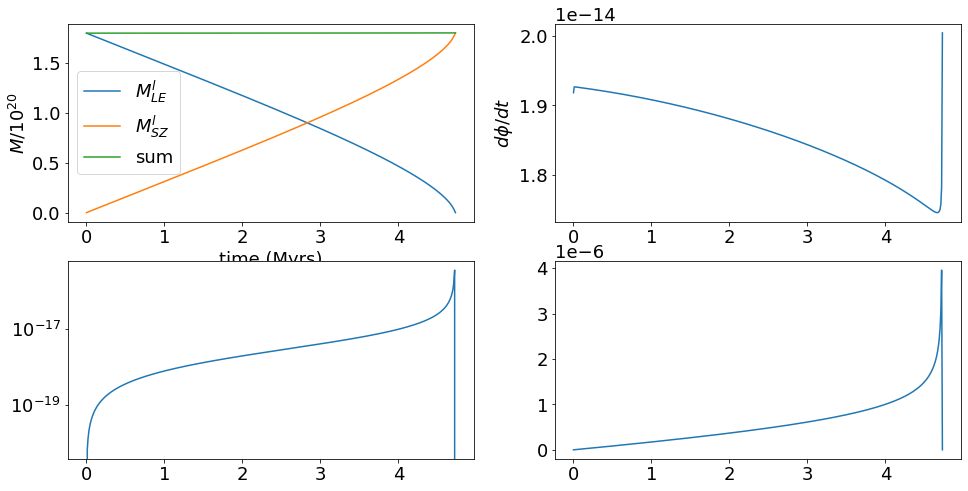

In [18]:
def plotone_useful_properties(fname):
    
    """Plots some useful properties for a single run to help interpret the solutions. Keys are: 
    
    Core: ['ri', 'rs', 'r_snow', 'T_cmb', 'conc_l', 'mf_l', 'M0', 'dM', 
    'initial_conc_l', 'Tcen', 'conc_s', 'dTm', 'c_cmb', 'T_upper', 
    'time', 'it', 'Q_cmb', 'Q_rs', 'alpha_D', 'o_rho_0', 'Qa', 'Qa_rs', 'ADR', 
    'ADR_s', 'Ql', 'El', 'Qg', 'Eg', 'Qg_mgo', 'Eg_mgo', 'Qr', 'Er', 'Qs', 'Es', 
    'Qsnow', 'Esnow', 'Ek', 'Eh', 'Ej', 'Ea', 'Ql_b', 'Ql_s', 'Ql_l', 'Qg_b', 'Qg_s', 
    'Qg_l', 'El_b', 'El_s', 'El_l', 'Eg_b', 'Eg_s', 'Eg_l', 'dr_snow_dt', 'Cp', 
    'L_r_snow', 'dT_dt', 'dri_dt', 'dc_dt', 'Cc', 'Cr', 'mf_s', 'mass_le_solid', 
    'mass_le_liq', 'mass_le_snow', 'L_ri', 'critical_failure_reason', 'profiles']
        
    """

    data = pickle.load(open(fname+".pik", 'rb')) #Read in dictionary from binary file

    fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(16,8))

    # Chk masses do not change
    print('M0, first, last = ', data['core']['M0'][0], data['core']['M0'][-1])
    print('dM, first, last = ', data['core']['dM'][0], data['core']['dM'][-1])
    
    time   = data['core']['time'] / (1e6*data['parameters']['ys'])  #Convert time from seconds to Myrs.
    dphidt = -data['core']['L_r_snow'] * data['core']['dT_dt'] / (data['core']['Tcen']**2 * data['core']['conc_l'])
    
    ax1.plot(time, data['core']['mass_le_liq']/1e20 , label="$M_{LE}^l$")
    ax1.plot(time, data['core']['mass_le_snow']/1e20, label="$M_{SZ}^l$")
    ax1.plot(time, (data['core']['mass_le_liq'] + data['core']['mass_le_snow'])/1e20, label="sum")
    ax1.set_xlabel("time (Myrs)")
    ax1.set_ylabel("$M/10^{20}$")
    ax1.legend()
    
    #ax2.plot(time, np.abs(data['core']['dT_dt']))
    ax2.plot(time, np.abs(dphidt))
    ax1.set_xlabel("time (Myrs)")
    ax2.set_ylabel("$d \\phi / dt$")
    
    ax3.plot(time, np.abs(data['core']['dc_dt']))
    ax3.set_yscale('log')

    ax4.plot(time, np.abs(data['core']['dc_dt']*data['core']['r_snow']**2))

file = "../500km/output_snow/S=5_q=10_adiabatic"
plotone_useful_properties(file)

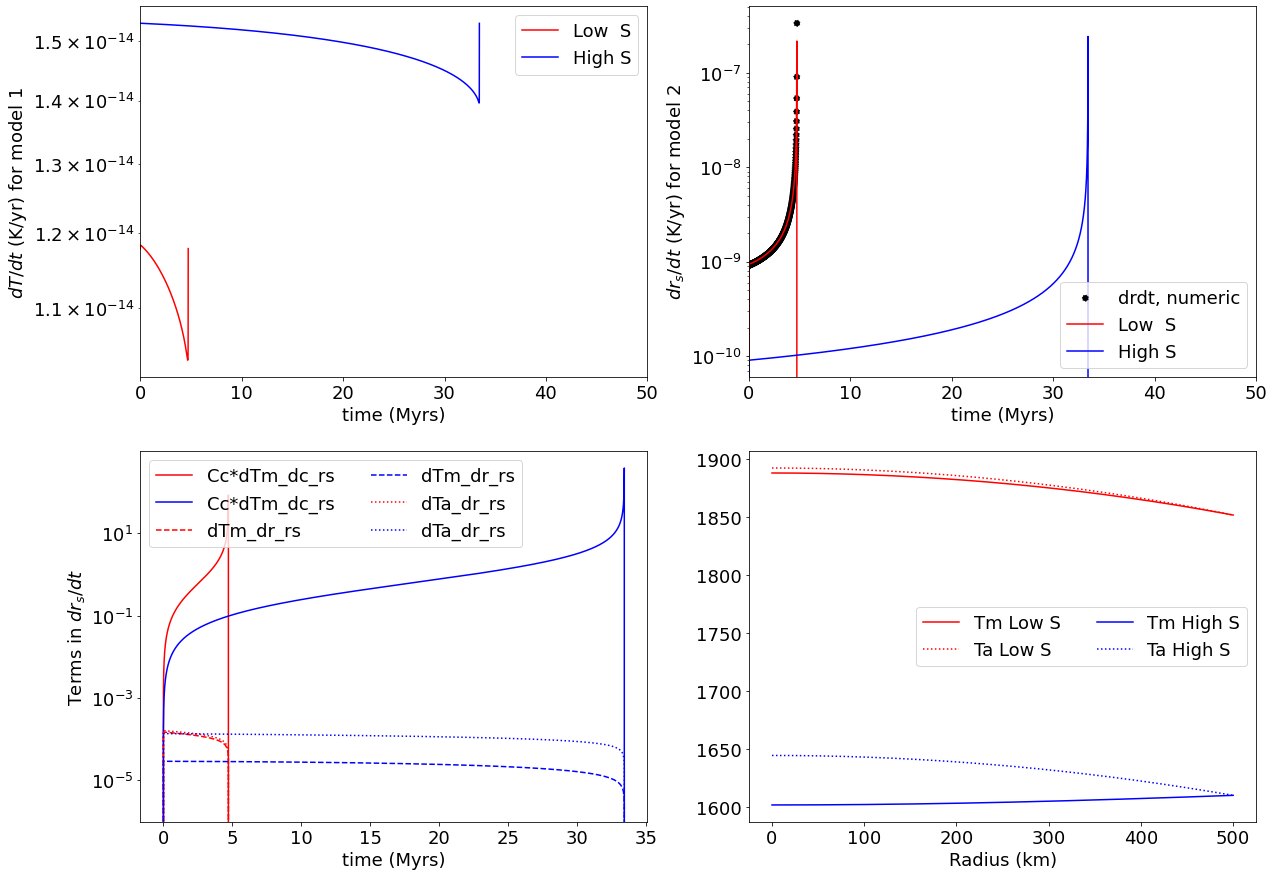

In [35]:
def compare_useful_properties(f1, f2, f3, f4):
    
    """Plots some useful properties to help interpret the solutions."""
    
    data1 = pickle.load(open(f1+".pik", 'rb')) #Read in dictionary from binary file
    data2 = pickle.load(open(f2+".pik", 'rb')) #Read in dictionary from binary file
    time1 = data1['core']['time'] / (1e6*data1['parameters']['ys'])  #Convert time from seconds to Myrs.
    time2 = data2['core']['time'] / (1e6*data2['parameters']['ys'])  #Convert time from seconds to Myrs.
    dt1   = data1['core']['time'][1::]   - data1['core']['time'][0:-1:]
    dr1   = data1['core']['r_snow'][1::] - data1['core']['r_snow'][0:-1:]
    
    #print('CC M1 = ', data1['core']['Cc'])
    #print('CC M2 = ', data2['core']['Cc'])
    
    fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(20,15))
    
    ax1.plot(time1, np.abs(data1['core']['dT_dt']), label="Low  S", color="red")
    ax1.plot(time2, np.abs(data2['core']['dT_dt']), label="High S", color="blue")
    ax1.set_xlim([0, 50])
    ax1.set_yscale('log')
    ax1.set_xlabel("time (Myrs)")
    ax1.set_ylabel("$dT/dt$ (K/yr) for model 1")
    ax1.legend()

    ax2.scatter(time1[1::], np.abs(dr1/dt1), label="drdt, numeric", color="black", linestyle=":")
    ax2.plot(time1, np.abs(data1['core']['dr_snow_dt']), label="Low  S", color="red")
    ax2.plot(time2, np.abs(data2['core']['dr_snow_dt']), label="High S", color="blue")
    ax2.set_xlim([0, 50])
    ax2.set_yscale('log')
    ax2.set_xlabel("time (Myrs)")
    ax2.set_ylabel("$dr_s /dt$ (K/yr) for model 2")
    ax2.legend()
    
    data3 = pickle.load(open(f3+".pik", 'rb')) #Read in dictionary from binary file
    data4 = pickle.load(open(f4+".pik", 'rb')) #Read in dictionary from binary file
    
    ax3.plot(time1, np.abs(data1['core']['dTm_dc_rs']*data1['core']['Cp']), label="Cc*dTm_dc_rs", linestyle="-", color="red")
    ax3.plot(time2, np.abs(data2['core']['dTm_dc_rs']*data2['core']['Cp']), label="Cc*dTm_dc_rs", linestyle="-", color="blue")        
    ax3.plot(time1, np.abs(data1['core']['dTmdr_rs']), label="dTm_dr_rs", linestyle="--", color="red")
    ax3.plot(time2, np.abs(data2['core']['dTmdr_rs']), label="dTm_dr_rs", linestyle="--", color="blue")
    ax3.plot(time1, np.abs(data1['core']['dTadr_rs']), label="dTa_dr_rs", linestyle=":", color="red")
    ax3.plot(time2, np.abs(data2['core']['dTadr_rs']), label="dTa_dr_rs", linestyle=":", color="blue")
    ax3.legend(loc="best", ncol=2)
    ax3.set_yscale('log')
    ax3.set_xlabel("time (Myrs)")
    ax3.set_ylabel("Terms in $d r_s /dt$")

    #ax3.set_xlim([0, 50])
    
    ax4.plot(data3['core']['profiles']['r']/1e3, data3['core']['profiles']['Tm'], label="Tm Low S", color="red", linestyle="-")
    ax4.plot(data3['core']['profiles']['r']/1e3, data3['core']['profiles']['Ta'], label="Ta Low S", color="red", linestyle=":")
    ax4.plot(data4['core']['profiles']['r']/1e3, data4['core']['profiles']['Tm'], label="Tm High S", color="blue", linestyle="-")
    ax4.plot(data4['core']['profiles']['r']/1e3, data4['core']['profiles']['Ta'], label="Ta High S", color="blue", linestyle=":")
    ax4.legend(ncol=2)
    ax4.set_xlabel("Radius (km)")
    
file1 = "../500km/output_snow/S=5_q=10_adiabatic"
file2 = "../500km/output_snow/S=15_q=10_adiabatic"
file3 = "../500km/output_snow/S=5_q=10_adiabatic_profiles_1"
file4 = "../500km/output_snow/S=15_q=10_adiabatic_profiles_1"
compare_useful_properties(file1, file2, file3, file4)

The top two panels show that increasing S concentration 1) increases cooling rate and; 2) decreases snow zone growth rate. Why? 

The relevant eqn is (20) of DP18: 

$$ \frac{d r_s}{d t} = 
\left[ \frac{1}{d T_l / dr - dT_a / dr} 
\left(\frac{T_s}{T_{cen}}  - C_p \frac{\partial T_m}{\partial c} \right) 
\right] 
\frac{d T_{cen}}{dt}$$  

If everything were constant w.r.t. S except cooling rate then $d r_s / dt$ would also increase, which is not what is observed. 

The adiabatic gradient is 

$$ \frac{d T_a}{ dr} = \frac{\alpha_T g T_a}{c_p} $$

Increasing S concentration from 5 -> 15 wt% decreases $\alpha_T$, $T_a$ and $C_p$, leaving the ratio almost constant (see cell below). 

By contrast $dT_l/dr$ decreases with increasing S as seen in the lower panels above. 

Therefore the denominator in the above eqn increases and hence $d r_s / dt$ decreases for fixed cooling rate. 

The factor $C_p \partial T_m / \partial c < 1$, such that this term combines with $T_s/T_{cen}$ to increase $d r_s / dt$. The term is larger at smaller S, reinforcing the effect from the denominator. 

So why does the cooling rate increase? The gravitational and latent heat terms due to snow all act to reduce the cooling rate and are proportional to the snow zone volume. At a given time, higher S runs have a thinner snow zone that lower S runs, so these terms are correspondingly reduced. The fact that the change in cooling rate as a function of S is small is consistent with this picture because the gravitational terms are small and the latent heat terms almost cancel in the total energy balance. The change in $d r_s / dt$ is larger than the change in $dT_a / dt$, consistent with two terms having opposite effects on the outcome. 

In [11]:
dTadr_lowS  = 6.39625882e-05 * 10 * 1900 / 745 # 5 wt%
dTadr_highS = 5.57859129e-05 * 10 * 1600 / 621 # 15 wt%

print(dTadr_lowS, dTadr_highS)

0.0016312606386577181 0.001437318206763285


# Look at a Flotation solution

Failed for:  
dict_keys(['ri', 'rs', 'r_snow', 'T_cmb', 'conc_l', 'mf_l', 'M0', 'dM', 'initial_conc_l', 'Tcen', 'conc_s', 'dTm', 'c_cmb', 'T_upper', 'time', 'it', 'Q_cmb', 'Q_rs', 'alpha_D', 'o_rho_0', 'Qa', 'Qa_rs', 'ADR', 'ADR_s', 'Ql', 'El', 'Qg', 'Eg', 'Qg_mgo', 'Eg_mgo', 'Qr', 'Er', 'Qs', 'Es', 'Ek', 'Eh', 'Ej', 'Ea', 'Ql_b', 'Ql_s', 'Ql_l', 'Qg_b', 'Qg_s', 'Qg_l', 'El_b', 'El_s', 'El_l', 'Eg_b', 'Eg_s', 'Eg_l', 'dr_snow_dt', 'Cp', 'L_r_snow', 'dT_dt', 'dri_dt', 'dc_dt', 'Cc', 'Cr', 'mf_s', 'mass_le_solid', 'mass_le_liq', 'mass_le_snow', 'L_ri', 'critical_failure_reason', 'profiles'])


Text(0, 0.5, 'r_snow')

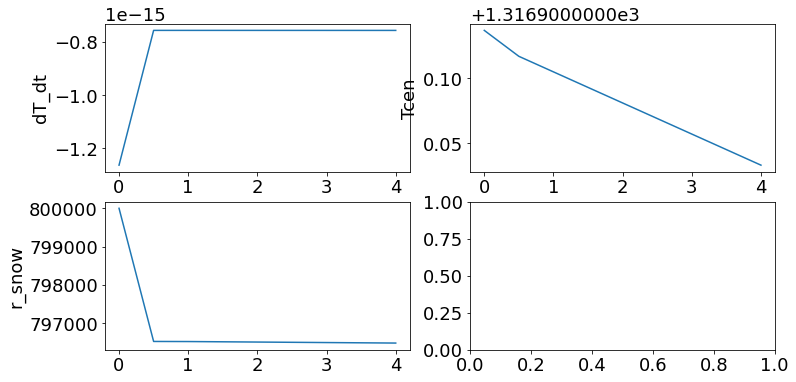

In [12]:
file = '../800km/output_float/S=25_q=1_adiabatic.pik'
if os.path.exists(file):
    with open(file,'rb') as open_file:
        data = pickle.load(open_file)
                
print('Failed for: ', data['core']['critical_failure_reason'])       
print(data['core'].keys())

tfac = 60*60*24*365*1e6

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2,figsize=(12,6))

ax1.plot(data['core']['time']/tfac, data['core']['dT_dt'])
ax1.set_ylabel("dT_dt")

ax2.plot(data['core']['time']/tfac, data['core']['Tcen'])
ax2.set_ylabel("Tcen")

ax3.plot(data['core']['time']/tfac, data['core']['r_snow'])
ax3.set_ylabel("r_snow")

dict_keys(['r', 'rho', 'g', 'P', 'cp', 'alpha', 'psi', 'Ta', 'dTa_dr', 'T', 'conc_l', 'dS', 'Tm_fe', 'Tm', 'dTm_dP', 'k', 'Qa', 'L', 'Cl', 'phi_snow'])


Text(0, 0.5, 'T')

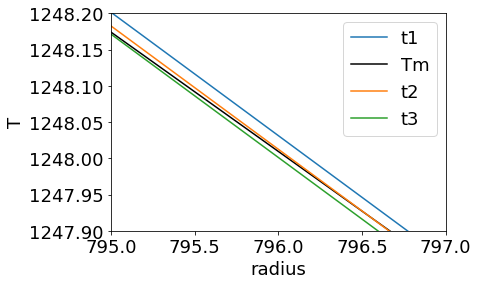

In [13]:
data1 = pickle.load(open('../800km/output_float/S=25_q=1_adiabatic_profiles_1.pik', 'rb'))
data2 = pickle.load(open('../800km/output_float/S=25_q=1_adiabatic_profiles_2.pik', 'rb'))
data3 = pickle.load(open('../800km/output_float/S=25_q=1_adiabatic_profiles_3.pik', 'rb'))

print(data['core']['profiles'].keys())

#plt.scatter(data['core']['profiles']['r']/1e3, data['core']['profiles']['T'])
#plt.scatter(data['core']['profiles']['r']/1e3, data['core']['profiles']['Tm'])
plt.plot(data1['core']['profiles']['r']/1e3, data1['core']['profiles']['T'], label="t1")
plt.plot(data1['core']['profiles']['r']/1e3, data1['core']['profiles']['Tm'], label="Tm", color="black")
plt.plot(data2['core']['profiles']['r']/1e3, data2['core']['profiles']['T'], label="t2")
plt.plot(data3['core']['profiles']['r']/1e3, data3['core']['profiles']['T'], label="t3")
plt.legend()
plt.xlim([795, 797])
plt.ylim([1247.9, 1248.2])
plt.xlabel("radius")
plt.ylabel("T")

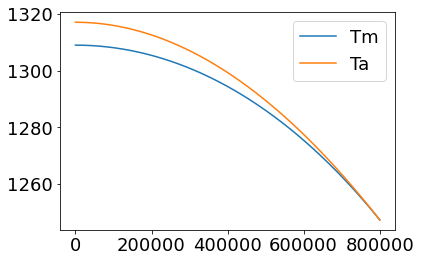

In [14]:
file = '../300km/output_float/S=25_q=1_adiabatic_profiles_10.pik'
if os.path.exists(file):
    with open(file,'rb') as open_file:
        data2 = pickle.load(open_file)

r, Tm, Ta = data2['core']['profiles']['r'], data2['core']['profiles']['Tm'], data2['core']['profiles']['Ta']
plt.plot(r, Tm, label="Tm")
plt.plot(r, Ta, label="Ta")
plt.legend()

In [15]:
print(data[0]['core']['profiles'].keys())

KeyError: 0

In [ ]:
t = data[0]['core']['profiles'].keys()
rs = data[0]['core']['r_snow']

#print(data[0]['core']['dr_snow_dt'])
#print(data[0]['core'].keys())

plt.plot(t, rs)

In [ ]:
P = data['core']['profiles']['P']

x_eu = 0.11 + 0.187*np.exp(-0.065e-9*P)

print(P)